# ***Playground Section 🎮***

In [ ]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('/content/Get_Data.csv')

# Filter the DataFrame to select only the rows where the category is 'sport' or 'politics'
filtered_df = df[df['Category'].isin(['sport', 'politics'])]

# Group the filtered DataFrame by the 'category' column
grouped_df = filtered_df.groupby('Category')

# Take the first 10 items from each group
selected_items = grouped_df.head(10)

print(selected_items.shape[0])

# Create an empty DataFrame to store the selected items
selected_df = pd.DataFrame()

# Iterate over the groups and select the first 10 items from each group
for category, group_df in grouped_df:
    selected_df = pd.concat([selected_df, group_df.head(10)], ignore_index=True)

# Print the selected DataFrame
print(selected_df)
selected_df.to_csv('add_data.csv', index=False)

20
                                               Author        Date Published  \
0                            Donald Judd,Jack Forrest  2023-01-31T05:14:49Z   
1   Michael Callahan,Jennifer Hansler,Haley Britzk...  2023-01-31T17:36:58Z   
2                                 Kevin Liptak,MJ Lee  2023-01-31T11:01:59Z   
3                         Jasmine Wright,Sonnet Swire  2023-01-31T20:00:20Z   
4                                        Sean Lyngaas  2023-01-31T20:51:22Z   
5                                         Daniel Dale  2023-01-31T20:43:06Z   
6                             Kyung Lah,Kate Sullivan  2023-01-31T17:27:49Z   
7       Paula Reid,Devan Cole,Jamie Gangel,Evan Perez  2023-01-31T18:46:07Z   
8                                     Oren Liebermann  2023-01-31T20:04:02Z   
9   Manu Raju,Melanie Zanona,Fredreka Schouten,Gre...  2023-01-31T15:05:38Z   
10                                         Ben Church  2023-02-28T08:48:09Z   
11                      Meron Moges-Gerbi,Jalen B

# ***Web Crawler Section ⛹***

In [ ]:
import logging
import sys
from collections import OrderedDict
from urllib.parse import urljoin
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [ ]:
# Web Crawler Class
class WebCrawler:
    def __init__(self, content_handler, save_file="CNN_Articles.csv", urls=None, stop_depth=sys.maxsize):
        self.logger = logging.getLogger(__name__)
        self.content_handler = content_handler
        self.save_file = save_file
        self.stop_depth = stop_depth
        self.visited_urls = set()
        self.urls_to_visit = OrderedDict([(x, 0) for x in urls])

    # This function takes a URL as an argument and returns the text content of
    # the web page at that URL. It uses the requests library to make an HTTP request
    # with some headers, and raises an exception if the request fails.
    def download_url_text(self, url):
        headers = {
            'User-Agent': "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36",
            "Upgrade-Insecure-Requests": "1", "DNT": "1",
            "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
            "Accept-Language": "en-US,en;q=0.5", "Accept-Encoding": "gzip, deflate"}
        source_code = requests.get(url, headers=headers)
        source_code.raise_for_status()
        return source_code.text

    # This function takes a URL and the HTML content of the web page at that URL as arguments,
    # and yields the links found in the HTML. It uses the BeautifulSoup library to parse the HTML
    # and find all the <a> tags, and filters out the links that are not valid or do not belong to the CNN domain.

    # yield like return keyword (return the value) in JS but it does not terminate the function but keep resuming the function
    # in this case, yield path simply means that we are returning the current path
    def get_urls_links(self, url, html):
        soup = BeautifulSoup(html, 'html.parser')
        for link in soup.find_all('a'):
            path = link.get('href')
            if not path:
                continue
            if path.startswith('/'):
                path = urljoin(url, path)
            if not path.startswith('https://edition.cnn.com/'):
                continue
            yield path

    # This function takes a URL as an argument, which is a tuple of the actual URL and its depth,
    # and adds it to the self.urls_to_visit dictionary if it meets the following conditions:
    #   + The depth of the URL is less than or equal to the self.stop_depth parameter.
    #   + The URL has not been visited before, i.e. it is not in the self.visited_urls set.
    def add_url_to_visit(self, url):
        if url[1] <= self.stop_depth:
            if url[0] not in self.visited_urls:
                self.urls_to_visit[url[0]] = url[1]

    # This function takes a URL as an argument, which is a tuple of the actual URL and its depth, and performs the following steps:
    #   + It downloads the text content of the web page at the URL using the download_url_text function.
    #   + It passes the text content to the self.content_handler object to process and extract the information.
    #   + It finds all the links in the text content using the get_urls_links function,
    #     and adds them to the self.urls_to_visit dictionary using the add_url_to_visit function.
    def crawl(self, url):
        html = self.download_url_text(url[0])
        self.content_handler.process_page(html)
        for curr_url in self.get_urls_links(url[0], html):
            self.add_url_to_visit((curr_url, url[1] + 1))

    # This is the main function of the class, which runs the crawler until
    # there are no more URLs to visit or the user interrupts the program. It does the following:
    #   + It loops through the self.urls_to_visit dictionary and pops the first URL and its depth.
    #   + It logs and prints the information about the current URL, such as its depth and the number of remaining URLs.
    #   + It tries to crawl the current URL using the crawl function, and handles any exceptions that may occur.
    #   + It adds the current URL to the self.visited_urls set.
    #   + If the user presses Ctrl+C, it asks the user if they want to save the content in the self.save_file file,
    #   + and calls the self.content_handler.save_content method if the answer is yes.
    def run(self):
        try:
            while self.urls_to_visit:
                curr_url = self.urls_to_visit.popitem(last=False)
                self.logger.info(f'Crawling: {curr_url[0]}, Depth: {curr_url[1]}, Remaining urls: {len(self.urls_to_visit)}')
                print(f'Crawling: {curr_url[0]}, Depth: {curr_url[1]}, Remaining urls: {len(self.urls_to_visit)}')
                try:
                    self.crawl(curr_url)
                except Exception as err:
                    self.logger.exception(f'Exception crawl: {curr_url[0]},  Depth: {curr_url[1]}, Error: {err}')
                    print(f'Exception crawl: {curr_url[0]},  Depth: {curr_url[1]}, Error: {err}')
                finally:
                    self.visited_urls.add(curr_url[0])
        except KeyboardInterrupt:
            user_input = input(f"\n\nKeyboard interrupt, do you want to save content in {self.save_file}? (Y/n): ")
            if user_input.lower() in ["no", "n"]:
                return
            pass
        self.content_handler.save_content(self.save_file)

In [ ]:
# CNN Content Handler Class
class CNNContentHandler:

    def __init__(self):
        self.logger = logging.getLogger(__name__)

        # A dictionary that stores the information of a single CNN article,
        # such as the author, date, headline, text, etc. It is initialized as None,
        # and will be filled by the file_article function.
        self.CNN_article = None

        # A pandas DataFrame that stores the information of all the CNN articles
        # that have been processed by the handler.
        # It is initialized as an empty DataFrame,
        # and will be updated by the add_article function.
        self.dataset = pd.DataFrame()

    # This function creates an empty dictionary with the keys corresponding
    # to the information of a CNN article, and assigns it to the self.CNN_article attribute.
    # This function is called by the process_page function before processing each web page.
    def create_empty_article(self):
        self.CNN_article = {
            'author': '',
            'date_published': '',
            'date_modified': '',
            'article_section': '',
            'url': '',
            'headline': '',
            'description': '',
            'keywords': '',
            'text': ''
        }

    # This function takes the HTML content of a web page as an argument,
    # and tries to extract the information of a CNN article from it.
    # It uses the BeautifulSoup library to parse the HTML and find the relevant tags and attributes.
    # It returns a boolean value indicating whether the web page is a valid CNN article or not.
    # If it is, it fills the self.CNN_article dictionary with the extracted information.
    # If not, it logs and prints the error and the missing information.
    def file_article(self, html):
        is_article = True
        soup = BeautifulSoup(html, 'html.parser')
        for script in soup(["script", "style"]):
            script.extract()

        page_type = soup.find("meta", {"name": "type"})
        if not page_type or page_type.attrs['content'] != "article":
            self.logger.info(f'Page is not of type "article". Actual type is: {page_type[:10] if page_type is str else None}')
            print(f'Page is not of type "article". Actual type is: {page_type[:10] if page_type is str else None}')
            return False

        try:
            self.CNN_article['author'] = soup.find("meta", {"name": "author"}).attrs['content'].strip()
            self.CNN_article['date_published'] = soup.find("meta", {"property": "article:published_time"}).attrs['content'].strip()
            self.CNN_article['date_modified'] = soup.find("meta", {"property": "article:modified_time"}).attrs['content'].strip()
            self.CNN_article['article_section'] = soup.find("meta", {"name": "meta-section"}).attrs['content']
            self.CNN_article['url'] = soup.find("meta", {"property": "og:url"}).attrs['content']
            self.CNN_article['headline'] = soup.find("h1", {"data-editable": "headlineText"}).text.strip()
            self.CNN_article['description'] = soup.find("meta", {"name": "description"}).attrs['content'].strip()
            self.CNN_article['keywords'] = soup.find("meta", {"name": "keywords"}).attrs['content'].strip()
            self.CNN_article['text'] = soup.find(itemprop="articleBody").text.strip()
        except Exception as err:
            is_article = False
            self.logger.info(f'Missing Article dataError: {err}')
            print(f'Missing Article dataError: {err}')
            for k, v in self.CNN_article.items():
                self.logger.info(f"{k}: {None if not v else v[:10] + '...'}")
                print(f"{k}: {None if not v else v[:10] + '...'}")
            self.logger.info(f'Missing Article dataError: {err}')
            print(f'Missing Article dataError: {err}')

        return is_article

    # This function adds the self.CNN_article dictionary as a row to the self.dataset DataFrame,
    # using the pandas concat function. This function is called by the process_page function after successfully filing an article.
    def add_article(self):
        self.dataset = pd.concat([self.dataset, pd.DataFrame([self.CNN_article])], ignore_index=True)

    # This function takes a filename as an argument, and saves the self.dataset DataFrame
    # as a CSV file using the pandas to_csv function.
    # This function can be called by the user after processing all the web pages.
    def save_content(self, filename):
        self.dataset.to_csv(filename)

    # This is the main function of the class, which takes the HTML content of a web page as an argument, and performs the following steps:
    #   + It calls the create_empty_article function to initialize an empty dictionary for the article information.
    #   + It calls the file_article function to extract the article information from the HTML content.
    #     It checks the return value of the function to see if the web page is a valid CNN article or not.
    #   + If it is, it calls the add_article function to add the article information to the dataset.
    def process_page(self, html):
        self.create_empty_article()
        is_article = self.file_article(html)
        if is_article:
            self.add_article()

In [ ]:
crawer_url_list = [
    "https://us.cnn.com/health/article/sitemap-2012-1.html",
    "https://us.cnn.com/health/article/sitemap-2012-2.html",
    "https://us.cnn.com/health/article/sitemap-2012-3.html",
    "https://us.cnn.com/health/article/sitemap-2012-4.html",
    "https://us.cnn.com/health/article/sitemap-2012-5.html",
    "https://us.cnn.com/health/article/sitemap-2012-6.html",
    "https://us.cnn.com/health/article/sitemap-2012-7.html",
    "https://us.cnn.com/health/article/sitemap-2012-8.html",
    "https://us.cnn.com/health/article/sitemap-2012-9.html",
    "https://us.cnn.com/health/article/sitemap-2012-10.html",
    "https://us.cnn.com/health/article/sitemap-2012-11.html",
    "https://us.cnn.com/health/article/sitemap-2012-12.html",

    "https://us.cnn.com/health/article/sitemap-2013-1.html",
    "https://us.cnn.com/health/article/sitemap-2013-2.html",
    "https://us.cnn.com/health/article/sitemap-2013-3.html",
    "https://us.cnn.com/health/article/sitemap-2013-4.html",
    "https://us.cnn.com/health/article/sitemap-2013-5.html",
    "https://us.cnn.com/health/article/sitemap-2013-6.html",
    "https://us.cnn.com/health/article/sitemap-2013-7.html",
    "https://us.cnn.com/health/article/sitemap-2013-8.html",
    "https://us.cnn.com/health/article/sitemap-2013-9.html",
    "https://us.cnn.com/health/article/sitemap-2013-10.html",
    "https://us.cnn.com/health/article/sitemap-2013-11.html",
    "https://us.cnn.com/health/article/sitemap-2013-12.html",

    "https://us.cnn.com/health/article/sitemap-2014-1.html",
    "https://us.cnn.com/health/article/sitemap-2014-2.html",
    "https://us.cnn.com/health/article/sitemap-2014-3.html",
    "https://us.cnn.com/health/article/sitemap-2014-4.html",
    "https://us.cnn.com/health/article/sitemap-2014-5.html",
    "https://us.cnn.com/health/article/sitemap-2014-6.html",
    "https://us.cnn.com/health/article/sitemap-2014-7.html",
    "https://us.cnn.com/health/article/sitemap-2014-8.html",
    "https://us.cnn.com/health/article/sitemap-2014-9.html",
    "https://us.cnn.com/health/article/sitemap-2014-10.html",
    "https://us.cnn.com/health/article/sitemap-2014-11.html",
    "https://us.cnn.com/health/article/sitemap-2014-12.html",

    "https://us.cnn.com/health/article/sitemap-2015-1.html",
    "https://us.cnn.com/health/article/sitemap-2015-2.html",
    "https://us.cnn.com/health/article/sitemap-2015-3.html",
    "https://us.cnn.com/health/article/sitemap-2015-4.html",
    "https://us.cnn.com/health/article/sitemap-2015-5.html",
    "https://us.cnn.com/health/article/sitemap-2015-6.html",
    "https://us.cnn.com/health/article/sitemap-2015-7.html",
    "https://us.cnn.com/health/article/sitemap-2015-8.html",
    "https://us.cnn.com/health/article/sitemap-2015-9.html",
    "https://us.cnn.com/health/article/sitemap-2015-10.html",
    "https://us.cnn.com/health/article/sitemap-2015-11.html",
    "https://us.cnn.com/health/article/sitemap-2015-12.html",

    "https://us.cnn.com/health/article/sitemap-2016-1.html",
    "https://us.cnn.com/health/article/sitemap-2016-2.html",
    "https://us.cnn.com/health/article/sitemap-2016-3.html",
    "https://us.cnn.com/health/article/sitemap-2016-4.html",
    "https://us.cnn.com/health/article/sitemap-2016-5.html",
    "https://us.cnn.com/health/article/sitemap-2016-6.html",
    "https://us.cnn.com/health/article/sitemap-2016-7.html",
    "https://us.cnn.com/health/article/sitemap-2016-8.html",
    "https://us.cnn.com/health/article/sitemap-2016-9.html",
    "https://us.cnn.com/health/article/sitemap-2016-10.html",
    "https://us.cnn.com/health/article/sitemap-2016-11.html",
    "https://us.cnn.com/health/article/sitemap-2016-12.html",

    "https://us.cnn.com/health/article/sitemap-2017-1.html",
    "https://us.cnn.com/health/article/sitemap-2017-2.html",
    "https://us.cnn.com/health/article/sitemap-2017-3.html",
    "https://us.cnn.com/health/article/sitemap-2017-4.html",
    "https://us.cnn.com/health/article/sitemap-2017-5.html",
    "https://us.cnn.com/health/article/sitemap-2017-6.html",
    "https://us.cnn.com/health/article/sitemap-2017-7.html",
    "https://us.cnn.com/health/article/sitemap-2017-8.html",
    "https://us.cnn.com/health/article/sitemap-2017-9.html",
    "https://us.cnn.com/health/article/sitemap-2017-10.html",
    "https://us.cnn.com/health/article/sitemap-2017-11.html",
    "https://us.cnn.com/health/article/sitemap-2017-12.html",

    "https://us.cnn.com/health/article/sitemap-2018-1.html",
    "https://us.cnn.com/health/article/sitemap-2018-2.html",
    "https://us.cnn.com/health/article/sitemap-2018-3.html",
    "https://us.cnn.com/health/article/sitemap-2018-4.html",
    "https://us.cnn.com/health/article/sitemap-2018-5.html",
    "https://us.cnn.com/health/article/sitemap-2018-6.html",
    "https://us.cnn.com/health/article/sitemap-2018-7.html",
    "https://us.cnn.com/health/article/sitemap-2018-8.html",
    "https://us.cnn.com/health/article/sitemap-2018-9.html",
    "https://us.cnn.com/health/article/sitemap-2018-10.html",
    "https://us.cnn.com/health/article/sitemap-2018-11.html",
    "https://us.cnn.com/health/article/sitemap-2018-12.html",

    "https://us.cnn.com/health/article/sitemap-2019-1.html",
    "https://us.cnn.com/health/article/sitemap-2019-2.html",
    "https://us.cnn.com/health/article/sitemap-2019-3.html",
    "https://us.cnn.com/health/article/sitemap-2019-4.html",
    "https://us.cnn.com/health/article/sitemap-2019-5.html",
    "https://us.cnn.com/health/article/sitemap-2019-6.html",
    "https://us.cnn.com/health/article/sitemap-2019-7.html",
    "https://us.cnn.com/health/article/sitemap-2019-8.html",
    "https://us.cnn.com/health/article/sitemap-2019-9.html",
    "https://us.cnn.com/health/article/sitemap-2019-10.html",
    "https://us.cnn.com/health/article/sitemap-2019-11.html",
    "https://us.cnn.com/health/article/sitemap-2019-12.html",

    "https://us.cnn.com/health/article/sitemap-2020-1.html",
    "https://us.cnn.com/health/article/sitemap-2020-2.html",
    "https://us.cnn.com/health/article/sitemap-2020-3.html",
    "https://us.cnn.com/health/article/sitemap-2020-4.html",
    "https://us.cnn.com/health/article/sitemap-2020-5.html",
    "https://us.cnn.com/health/article/sitemap-2020-6.html",
    "https://us.cnn.com/health/article/sitemap-2020-7.html",
    "https://us.cnn.com/health/article/sitemap-2020-8.html",
    "https://us.cnn.com/health/article/sitemap-2020-9.html",
    "https://us.cnn.com/health/article/sitemap-2020-10.html",
    "https://us.cnn.com/health/article/sitemap-2020-11.html",
    "https://us.cnn.com/health/article/sitemap-2020-12.html",

    "https://us.cnn.com/health/article/sitemap-2021-1.html",
    "https://us.cnn.com/health/article/sitemap-2021-2.html",
    "https://us.cnn.com/health/article/sitemap-2021-3.html",
    "https://us.cnn.com/health/article/sitemap-2021-4.html",
    "https://us.cnn.com/health/article/sitemap-2021-5.html",
    "https://us.cnn.com/health/article/sitemap-2021-6.html",
    "https://us.cnn.com/health/article/sitemap-2021-7.html",
    "https://us.cnn.com/health/article/sitemap-2021-8.html",
    "https://us.cnn.com/health/article/sitemap-2021-9.html",
    "https://us.cnn.com/health/article/sitemap-2021-10.html",
    "https://us.cnn.com/health/article/sitemap-2021-11.html",
    "https://us.cnn.com/health/article/sitemap-2021-12.html",

    "https://us.cnn.com/health/article/sitemap-2022-1.html",
    "https://us.cnn.com/health/article/sitemap-2022-2.html",
    "https://us.cnn.com/health/article/sitemap-2022-3.html",
    "https://us.cnn.com/health/article/sitemap-2022-4.html",
    "https://us.cnn.com/health/article/sitemap-2022-5.html",
    "https://us.cnn.com/health/article/sitemap-2022-6.html",
    "https://us.cnn.com/health/article/sitemap-2022-7.html",
    "https://us.cnn.com/health/article/sitemap-2022-8.html",
    "https://us.cnn.com/health/article/sitemap-2022-9.html",
    "https://us.cnn.com/health/article/sitemap-2022-10.html",
    "https://us.cnn.com/health/article/sitemap-2022-11.html",
    "https://us.cnn.com/health/article/sitemap-2022-12.html",
]

In [ ]:
if __name__ == '__main__':
    content_handler = CNNContentHandler()
    WebCrawler(content_handler,
               # urls=['https://edition.cnn.com/sitemap.html'],
               urls=crawer_url_list,
               stop_depth=1,
               save_file="test_again_full.csv").run()

Crawling: https://us.cnn.com/health/article/sitemap-2012-1.html, Depth: 0, Remaining urls: 131
Page is not of type "article". Actual type is: None
Crawling: https://us.cnn.com/health/article/sitemap-2012-2.html, Depth: 0, Remaining urls: 130
Page is not of type "article". Actual type is: None
Crawling: https://us.cnn.com/health/article/sitemap-2012-3.html, Depth: 0, Remaining urls: 129
Page is not of type "article". Actual type is: None
Crawling: https://us.cnn.com/health/article/sitemap-2012-4.html, Depth: 0, Remaining urls: 128
Page is not of type "article". Actual type is: None
Crawling: https://us.cnn.com/health/article/sitemap-2012-5.html, Depth: 0, Remaining urls: 127
Page is not of type "article". Actual type is: None
Crawling: https://us.cnn.com/health/article/sitemap-2012-6.html, Depth: 0, Remaining urls: 126
Page is not of type "article". Actual type is: None
Crawling: https://us.cnn.com/health/article/sitemap-2012-7.html, Depth: 0, Remaining urls: 125
Page is not of type "ar

# ***Filter Dataset Section 👌***

In [ ]:
# Import pandas library
import pandas as pd

In [ ]:
# Read the dataset from session storage
df = pd.read_csv('/content/modified_file.csv', lineterminator='\n')

In [ ]:
# print data for testing
df

In [ ]:
# Drop the columns 'Category' and 'Second headline'
# df = df.drop(['Category', 'Second headline'], axis=1)

# Rename the column 'Section' to 'Category'
# df = df.rename(columns={'Section': 'Category'})

# Keep only the rows with values in the enum list in Category column (Section Before)
df = df[df['Category'].isin(['business', 'entertainment', 'health', 'sport', 'politics'])]

In [ ]:
# Print df after processing
df['Category'].value_counts()

In [ ]:
# Save the dataframe as a CSV file
df.to_csv('Processed_Dataset.csv', index=False)

In [ ]:
# Import pandas library
import pandas as pd

In [ ]:
# Read the dataset from session storage
df = pd.read_csv('/content/drive/MyDrive/ClassificationProject/CNN_Articles_Raw.csv')

In [ ]:
# sorting by index
df.sort_values("index", inplace = True)

In [ ]:
# remove duplicate row in the dataset

# subset: Takes a column or list of column label. It’s default value is none. After passing columns, it will consider them only for duplicates.
# keep: Controls how to consider duplicate value. It has only three distinct value and default is ‘first’.
# –> If ‘first’, it considers first value as unique and rest of the same values as duplicate.
# –> If ‘last’, it considers last value as unique and rest of the same values as duplicate.
# –> If False, it consider all of the same values as duplicates.

df.duplicated(subset=None, keep='first')

In [ ]:
# export to csv file
df.to_csv('CNN_Articels_clean.csv', index=False)

# ***Text Preprocessing 💰***

## Normalization

In [ ]:
import pandas as pd
import string # used for removing punctuation

In [ ]:
#read the csv file from google colab
df = pd.read_csv('/content/drive/MyDrive/ClassificationProject/Processed_Dataset.csv')

In [ ]:
# print for testing
df['Category'].value_counts()

In [ ]:
#select the Article text column
articleText = df['Article text']

In [ ]:
#convert the text to lowercase
articleText = articleText.str.lower()

In [ ]:
#remove punctuation using String Translate (import string library)
articleText = articleText.str.translate(str.maketrans('', '', string.punctuation))

In [ ]:
#print the result for testing
print(articleText)

In [ ]:
# reasign otherwise df.to_csv will export for us the old dataset
# since we just only manipulate the articleText not the dataset so we have to
# assign it again to the dataset so inside the dataset will have changes
# or we can use the parameter inplace = true
df['Article text'] = articleText

In [ ]:
# delete one by one like column is 'Unnamed: 0' so use it's name
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
# Save the dataframe as a CSV file
df.to_csv('Normalize_Dataset.csv', index=False)

## Tokenization, Lemmazation And Stop Word Removal

In [ ]:
# - stop word removal --> remove all the unimportant word (a, an, the, ...)
# - lemmazation --> convert word to its orginal word form
# +   meeting -> meet
# +   mice --> mouse
# +   received -> receive

In [ ]:
import pandas as pd
import nltk #used for tokenization
from nltk.corpus import stopwords # stop word removal
from nltk.stem import PorterStemmer # stemming
from nltk.stem import WordNetLemmatizer # lemma

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
# Read the CSV file from Google Colab
df = pd.read_csv('/content/drive/MyDrive/ClassificationProject/Normalize_Dataset.csv', lineterminator='\n')

In [ ]:
# print for testing
df['Category'].value_counts()

In [ ]:
# drop any rows that have empty values in the ‘Article text’ column
# the row with index = 32187 has empty value in article text column
# which cause error when running the tokenize_and_log function
df = df.dropna(subset=['Article text'])

# Import the stopwords module from nltk.corpus and assign it to a variable
stop_words = set(stopwords.words('english'))
print(stop_words)

In [ ]:
df.head()

In [ ]:
# Define a custom function that takes a row and returns the tokenize word
# and not in the stop_words list and also lemma the word
def tokenize_and_log(row):
  # Create WordNetLemmatizer object
  wnl = WordNetLemmatizer()

  # Get the text from the 'Article text' column
  text = row['Article text']
  # Tokenize the text using nltk
  tokens = nltk.word_tokenize(text)

  # Use a list comprehension to iterate over the tokens and filter out the ones
  # that are in the stop_words list and lemma them using wnl.lemmatize
  filtered_and_lemma_tokens = [wnl.lemmatize(token) for token in tokens if token not in stop_words]

  # Return the filtered tokens
  return filtered_and_lemma_tokens

# Apply the custom function to the dataframe and
# assign the result to a new column
df['tokenization'] = df.apply(tokenize_and_log, axis=1)

In [ ]:
# print for testing
print(df['tokenization'][1])

In [ ]:
# remove any row that has a non-numeric value in the Index column is to use the
# pd.to_numeric function with the errors='coerce' argument.
# This will convert any non-numeric value to NaN,
# which we can then filter out using the notnull method

# The errors='coerce' argument is used in some pandas functions to handle invalid values.
# It means that any value that cannot be converted to the desired data type will be replaced with NaN
df = df[pd.to_numeric(df['Index'], errors='coerce').notnull()]

# export to csv file
df.to_csv('Text_Preprocessing_Dataset.csv', index=False)

# ***Feature Engineering 😘***

In [ ]:
# Import pandas library
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Read the dataset from session storage
df = pd.read_csv('/content/drive/MyDrive/Text_Preprocessing_Dataset.csv', lineterminator='\n')

In [ ]:
print(df.columns)

In [ ]:
max_features = 10000  # Limit the vocabulary to the top n most frequent words in the entire dataset
min_df = 50  # Exclude terms that appear in fewer than n documents (single item in article_text column)

# Initialize the CountVectorizer
count_vect = CountVectorizer(max_features=max_features)

In [ ]:
# Fit and transform the documents
bow_matrix = count_vect.fit_transform(df['Article text'])

In [ ]:
# bow_matrix

# 1: 269.174 (original), 2:5000, 3: 5374, 4: 100.000 (will comeback to this later), 5: 50.000 (currently)
len(count_vect.get_feature_names_out())

# print all the items in our global vocabulary
# print(count_vect.vocabulary_.items())

In [ ]:
# Create a new column with the word counts
df["counts"] = bow_matrix.toarray().tolist()

In [ ]:
# Save the dataframe as a CSV file
df.to_csv('BOW_Dataset.csv', index=False)

# ***Label Encoded 🙋***

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# Read the dataset from session storage
df = pd.read_csv('/content/drive/MyDrive/ClassificationProject/BOW_Dataset.csv', lineterminator='\n')

In [ ]:
df['Category'].value_counts()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 'Category' is the column we want to encode
category_encoder = LabelEncoder()
df['Category_Encoded'] = category_encoder.fit_transform(df['Category'])

In [ ]:
# Print the mapping between original labels and numerical values
label_mapping = dict(zip(category_encoder.classes_, category_encoder.transform(category_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)

In [ ]:
# Inspect the DataFrame
# {'business': 0, 'entertainment': 1, 'health': 2, 'politics': 3, 'sport': 4}
df['Category_Encoded']

In [ ]:
# Save the dataframe as a CSV file
df.to_csv('New_Crawler_Complete_Processed_Dataset.csv', index='true')

# ***Logistic Model  1️⃣***

## ***Implement Model***

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Visualize confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load your dataset
file_path = '/content/drive/MyDrive/New_Crawler_After_EDA_And_Complete_Processing.csv'
df = pd.read_csv(file_path, lineterminator='\n', index_col='Index').convert_dtypes()

In [ ]:
# Split the dataset into training and testing sets
# stratify=df['Category'] ensures that the class distribution in df['Category'] is preserved during the splitting process.
# X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df['Article_Text'], df['Category'], test_size=0.2, random_state=42, stratify=df['Category'])

# Normal Random Sampling Technique
X_train, X_test, y_train, y_test = train_test_split(df['Article_Text'], df['Category_Encoded'], test_size=0.2, random_state=42)

In [ ]:
# Check class distribution in the original dataset
print("Original Class Distribution:")
print(df['Category'].value_counts())

Original Class Distribution:
sport            5638
health           4547
entertainment    2658
politics         2461
business         1362
Name: Category, dtype: Int64


In [ ]:
# Check class distribution in the training set
print("Training Set Class Distribution:")
print(y_train.value_counts())

# Check class distribution in the testing set
print("Testing Set Class Distribution:")
print(y_test.value_counts())

Training Set Class Distribution:
4    4455
2    3699
1    2129
3    1976
0    1073
Name: Category_Encoded, dtype: Int64
Testing Set Class Distribution:
4    1183
2     848
1     529
3     485
0     289
Name: Category_Encoded, dtype: Int64


In [ ]:
# Check class distribution in the training set
# print("Training Set Class Distribution:")
# print(y_train_2.value_counts())

# Check class distribution in the testing set
# print("Testing Set Class Distribution:")
# print(y_test_2.value_counts())

In [ ]:
# Convert text data to BOW representation
max_features = 10000
vectorizer = CountVectorizer(max_features=max_features)
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [ ]:
# Train a logistic regression model (softmax regression for multiclass classification)
# multi_class='multinomial': Specifies that the problem is a multinomial (softmax) regression problem.
# solver='lbfgs': Specifies the optimization algorithm to be used for training the model.
# max_iter=1000 sets the maximum number of iterations for the solver
logistic_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
logistic_model.fit(X_train_bow, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [ ]:
# Make predictions on the test set
y_pred = logistic_model.predict(X_test_bow)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [ ]:
# + Accuracy: 0.96: This represents the overall correctness of your model.
# In your case, it means that the model correctly predicted the class for 96% of the samples.
# + Classification Report: The classification report provides more detailed metrics for each class in your dataset.
# ++ Precision: Precision is the ratio of correctly predicted positive observations to the total predicted positives.
# High precision relates to the low false positive rate.
# Formula: Precision = TP / (TP + FP)
# ++ Recall (Sensitivity): Recall is the ratio of correctly predicted positive observations to all actual positives.
# It is also known as Sensitivity or True Positive Rate.
# Formula: Recall = TP / (TP + FN)
# ++ Support: Support is the actual number of occurrences of the class in the specified dataset.

# In summary, your model has an overall accuracy of 96%,
# and the classification report gives you detailed information about how well your model
# performs on each individual class. It's important to consider precision, recall,
# and F1-Score together to get a comprehensive understanding of your model's performance,
# especially in the context of imbalanced datasets.

print(f'Accuracy: {accuracy:.2f}')

print("Confusion Matrix:")
print(cm)

print('Classification Report:')
print(report)

Accuracy: 0.97
Confusion Matrix:
[[ 272    4    5    4    4]
 [   2  509    7    3    8]
 [   3    4  824   10    7]
 [   3    5   10  465    2]
 [   1    8    6    1 1167]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95       289
         1.0       0.96      0.96      0.96       529
         2.0       0.97      0.97      0.97       848
         3.0       0.96      0.96      0.96       485
         4.0       0.98      0.99      0.98      1183

    accuracy                           0.97      3334
   macro avg       0.97      0.96      0.97      3334
weighted avg       0.97      0.97      0.97      3334



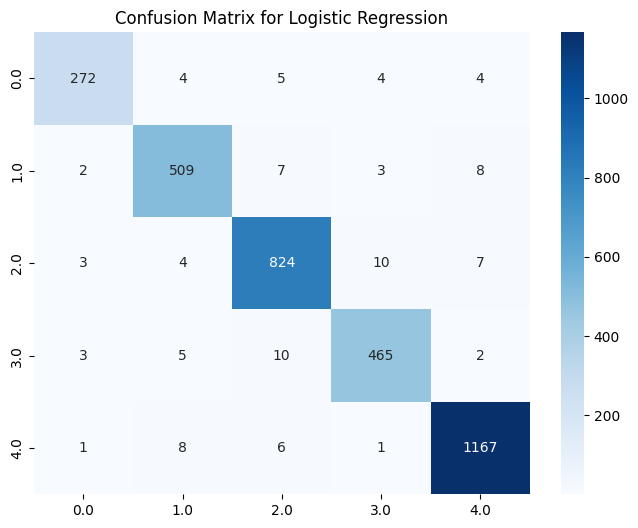

In [ ]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=logistic_model.classes_, yticklabels=logistic_model.classes_)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

In [ ]:
# Collect and print or visualize samples that were misclassified to
# understand the patterns or reasons behind misclassification.
misclassified_samples = X_test[y_test != y_pred]
misclassified_labels = y_test[y_test != y_pred]
print("Misclassified Samples:")
print(misclassified_samples)
print("True Labels:")
print(misclassified_labels)

## ***Testing Model***

In [ ]:
# Assuming 'new_text' contains your new blog content
new_text = """
    Weeks after the Biden administration laid out the details of a $105 billion national security package that includes funding for both Israel and Ukraine, Senate Majority Leader Chuck Schumer said he would bring the supplemental request to the floor as soon as next week.

But the effort faces steep hurdles in getting through Congress. Among them: The House and Senate are divided over whether to continue sending aid to Ukraine, and Republican lawmakers want to tie the funding to tightening immigration laws.

The supplemental package would provide security support to Israel, bolster Israeli efforts to secure the release of hostages and extend humanitarian aid to civilians affected by the war in Israel and Gaza, according to a White House fact sheet released in October.
It would also provide training, equipment and weapons to help Ukraine defend itself against Russia’s invasion and to recapture its territory, as well as to protect Ukrainians from Russian aggression, the fact sheet said.

The package would also include additional funds to support US-Mexico border security, including more patrol agents, machines to detect fentanyl, asylum officers and immigration judge teams. Plus, it would provide funding to strengthen security in the Indo-Pacific region, including Taiwan.
$61.4 billion in aid for Ukraine
$30 billion for the Defense Department for equipment for Ukraine and the replenishment of US stocks. So far, the US has provided Ukraine with air defense systems, munitions, small arms and ground maneuver units, among other weapons and equipment.
$14.4 billion for continued military, intelligence and other defense support. This includes investments in the defense industrial base, transportation costs of US personnel and equipment, and continuing an enhanced US troop presence in Europe, among other activities.
$16.3 billion for economic, security and operational assistance. It includes direct budget support to Ukraine to help it provide critical services to its people and sustain its economy, as well as investments in infrastructure, civilian law enforcement and getting rid of mines.
$481 million to support Ukrainians arriving in the US through the Uniting for Ukraine program.
$149 million for the National Nuclear Security Administration for nuclear/radiological incident response and capacity building in case of emergencies as part of general
$14.3 billion in aid for Israel
$10.6 billion for assistance through the Defense Department, including air and missile defense support, industrial base investments and replenishment of US stocks being drawn down to support Israel.
The aid aims to bolster Israel’s air and missile defense system readiness and support its procurement of Iron Dome and David’s Sling missile defense systems and components, as well as the development of the Iron Beam.
$3.7 billion for the State Department to strengthen Israel’s military and enhance US Embassy security.
$10 billion for humanitarian assistance
$9.15 billion for aid for Ukraine, Israel, Gaza and other humanitarian needs. It includes support for Palestinian refugees in the West Bank and surrounding areas.
$850 million for migration and refugee assistance at the US-Mexico border.
$7.4 billion for Taiwan and the Indo-Pacific region
The security assistance aims to bolster deterrence and to support allies facing increasing assertiveness from China and transitioning off Russian military equipment.
$2 billion for foreign military financing.
$3.4 billion for the submarine industrial base. It would fund improvements at the Navy’s four public shipyards and increase submarine availability.
$2 billion for the Treasury Department to provide a “credible alternative to coercive financing” and to catalyze billions from other donors through the US-led World Bank. The administration is seeking to offer options other than China’s “coercive and unsustainable financing for developing countries.”
$13.6 billion to address security at the US-Mexico border
$6.4 billion for border operations, including additional temporary holding facilities, DNA collection at the border and support for eligible arrivals and unaccompanied children.
$3.1 billion for an additional 1,300 Border Patrol agents, 1,600 asylum officers, processing personnel and 375 immigration judge teams.
$1.4 billion for state and local support for temporary shelter, food and other services for migrants recently released from Department of Homeland Security custody.
$1.2 billion to counter fentanyl, including inspection system deployment, additional Customs and Border Protection officers, and testing and tracing activities.
$1.4 billion for migration needs to support Safe Mobility Offices, for host communities and legal pathways in the region, for foreign government repatriation operations and to combat human trafficking and smuggling in the Western Hemisphere.
$100 million for child labor investigations and enforcement, particularly to protect migrant children entering the US through the southern border.
"""

In [ ]:
# Convert the text to BOW representation
new_bow = vectorizer.transform([new_text])
# Make a prediction
predicted_category = logistic_model.predict(new_bow)

In [ ]:
# Convert the predicted category back to the original label if needed
# (use the inverse of the label encoder)
# predicted_category_label = label_encoder.inverse_transform(predicted_category)

In [ ]:
print(f"Predicted Category: {predicted_category}")

Predicted Category: [3.]


# ***SVM Model 2️⃣***

## ***Implement***

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load your dataset (assuming a DataFrame with 'article_text' and 'category' columns)
data = pd.read_csv("/content/drive/MyDrive/New_Crawler_After_EDA_And_Complete_Processing.csv", lineterminator='\n')

In [ ]:
# 2. Feature Extraction (BOW)
max_features = 10000
vectorizer = CountVectorizer(max_features=max_features)
X = vectorizer.fit_transform(data['Article_Text'])  # Transform text data into BOW representation
y = data['Category_Encoded']  # Target labels

In [ ]:
# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 4. Model Training
svm_classifier = LinearSVC()  # Linear Support Vector Classifier
svm_classifier.fit(X_train_bow, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [ ]:
# 5. Model Evaluation
y_pred = svm_classifier.predict(X_test_bow)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[ 274    1    5    4    5]
 [   2  507    8    4    8]
 [   5    7  810   11   15]
 [   3    6    8  465    3]
 [   4    7    5    3 1164]]
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       289
         1.0       0.96      0.96      0.96       529
         2.0       0.97      0.96      0.96       848
         3.0       0.95      0.96      0.96       485
         4.0       0.97      0.98      0.98      1183

    accuracy                           0.97      3334
   macro avg       0.96      0.96      0.96      3334
weighted avg       0.97      0.97      0.97      3334



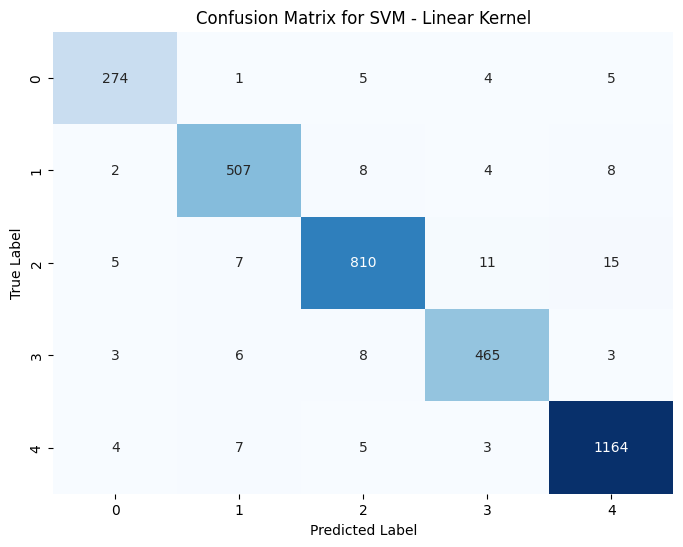

In [ ]:
# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for SVM - Linear Kernel')
plt.show()

In [ ]:
joblib.dump(svm_classifier, "/content/drive/MyDrive/SVM_Linear_Kernel1.joblib")

['/content/drive/MyDrive/SVM_Linear_Kernel1.joblib']

## ***Grid Search***

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

In [ ]:
parameters_dictionary = {
    'kernel':['linear', 'rbf', 'poly'],
    'C':[1, 10, 100],
    'gamma':[1, 10, 100]
}
scoring_metric = make_scorer(f1_score, average='weighted')

In [ ]:
svc = SVC()

grid_search = GridSearchCV (
    svc,
    parameters_dictionary,
    return_train_score=True,
    cv = 5,
    verbose = 3, # Displays how many combinations of parameters and folds we'll have, for more information as the time to run each search, use 2 or 3 values instead of 1)
    scoring=scoring_metric
)


In [ ]:
# Running grid search on train data
grid_search.fit(X_train, y_train)

In [ ]:
best_model = grid_search.best_estimator_
best_parameters = grid_search.best_params_
best_f1 = grid_search.best_score_

print('The best model was:', best_model)
print('The best parameter values were:', best_parameters)
print('The best f1-score was:', best_f1)

## ***Testing***

In [ ]:
text = '''
Tap water is not sterile, and using it in home medical devices can result in serious and even deadly infections. But in a study published Wednesday in the journal Emerging Infectious Diseases, one-third of respondents to a survey incorrectly answered that tap water does not contain bacteria or other living organisms.In the August 2021 survey, more than half of 1,004 survey participants incorrectly said that tap water can be used for nasal rinsing, 50% believed is appropriate for rinsing contact lenses and 42% trusted it is safe for use in respiratory devices such as humidifiers or CPAP – continuous positive airway pressure – machines, which are used to treat sleep apnea.Shanna Miko, an author of the study and Epidemic Intelligence Service officer at the US Centers for Disease Control and Prevention, says these findings highlight misconceptions about the safe use of nonsterile tap water for medical devices at home.“While tap water is generally safe to drink, it is not OK for other uses,” Miko said.Although US tap water is treated to meet safe drinking standards, it may contain low levels of microorganisms.These microbes are generally harmless when ingested during drinking and cooking because they are killed by stomach acid. However, when irrigating the nose or eyes, they may cause serious and even deadly infections.“With the aging infrastructure, our aging pipes, there are some new waterborne challenges that have emerged, and those are basically these pathogens or these germs that can live in these protective areas that like to stick to pipes called biofilm pathogens,” Miko said.Pathogens found in tap water systems – including Pseudomonas aeruginosa, nontuberculous mycobacteria, Legionella, Acanthamoeba and Naegleria fowleri – can invade the lungs, brain, eyes or skin.Several cases of brain-eating amoeba have been reported from neti pots, devices used to flush nasal passages. There have also been multi-state outbreaks of Acanthamoeba from improper contact lens rinsing, which can cause blindness and other permanent eye damage.“They might not be the most frequent things to be occurring each year,” Miko said, “but to the people that do acquire the infections, it has a significant impact.”Most healthy people exposed to these microbes will not get sick. However, certain groups of people may be at a higher risk of serious infection. These include older people, infants younger than 6 months, and those with weakened immune systems or other chronic health issues such as cancer, HIV or lung disease.“We want them to know that even though they’re at higher risk for infections of these waterborne associated pathogens, there are simple steps that they can take to reduce their risks,” Miko said.The CDC recommends individuals using at-home medical devices like CPAP machines, humidifiers and neti pots only use water free from microbes such as distilled or sterile water, which can be bought in stores. Boiled and cooled water may also be used.In addition to using distilled, sterile or previously boiled water, individuals can decrease their exposure to microbes by regularly cleaning and disinfecting at-home medical devices.For populations at higher risk, Miko recommends flushing plumbing systems regularly and applying special filters on faucets or showers. She notes that most pitcher, refrigerator and sink water filters are not designed to remove germs from water.“This data isn’t meant to scare anybody. We have one of the best public water drinking systems in the world,” Miko said.She encourages people to follow guidance on safe water practices for at-home medical devices which can be found on the CDC website.“If we can just do something as simple as boiling water or using sterile distilled water to reduce the risk, that’s something we’d like to share with people,” Miko said.'''

In [ ]:
# Convert the text to BOW representation
new_bow = vectorizer.transform([text])
# Make a prediction
predicted_category = svm_classifier.predict(new_bow)

In [ ]:
print(predicted_category)

[2.]


# ***Nerual Network 3️⃣***

## **Implement**

In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.regularizers import l2

In [ ]:
file_path = '/content/New_Crawler_After_EDA_And_Complete_Processing.csv'
df = pd.read_csv(file_path, lineterminator='\n')

In [ ]:
import tensorflow as tf

# Đường dẫn tới tệp .h5 chứa mô hình đã được lưu
model_path = "/content/drive/MyDrive/Bản sao của Seq_model1.h5"

# Tải mô hình từ tệp .h5
model = tf.keras.models.load_model(model_path)

In [ ]:
df.head()

,Index,Author,Date_Published,Category,Url,Headline,Description,Keywords,Article_Text,tokenization,Category_Encoded
0,0,"Nathaniel Meyersohn, CNN Business",2022-03-19 12:10:14,business,https://www.cnn.com/2022/03/19/business/kohls-...,How Kohl's became such a mess - CNN,"In 2018, Kohl's was a bright spot in the belea...","business, How Kohl's became such a mess - CNN",new york cnn businessin 2018 kohls was a brigh...,"['new', 'york', 'cnn', 'businessin', '2018', '...",0
1,1,"Ramishah Maruf, CNN",2022-03-20 20:44:33,business,https://www.cnn.com/2022/03/20/business/disney...,Disney said it regrets racist cheer by high sc...,Disney said it regrets a performance at its Or...,"business, Disney said it regrets racist cheer ...",cnndisney said it regrets a performance at it...,"['cnndisney', 'said', 'regret', 'performance',...",0
2,3,"Laura He, CNN Business",2022-03-17 11:14:49,business,https://www.cnn.com/2022/03/17/business/china-...,China Russia: 4 ways China is quietly making l...,China is quietly distancing itself from Russia...,"business, China Russia: 4 ways China is quietl...",hong kong cnn businesschina is quietly distanc...,"['hong', 'kong', 'cnn', 'businesschina', 'quie...",0
3,4,"Jordan Valinsky, CNN Business",2022-03-19 09:29:57,business,https://www.cnn.com/2022/03/19/business/budwei...,Budweiser's slogan wasn't always the 'King of ...,"Budweiser's slogan, the ""King of Beers,"" is as...","business, Budweiser's slogan wasn't always the...",new york cnn businessbudweisers slogan the kin...,"['new', 'york', 'cnn', 'businessbudweisers', '...",0
4,5,"Diksha Madhok, CNN Business",2021-11-02 11:02:09,business,https://www.cnn.com/2021/11/02/business/adar-p...,Adar Poonawalla: He vaccinates half the world'...,As Covid-19 wreaked havoc around the world las...,"business, Adar Poonawalla: He vaccinates half ...",as covid19 wreaked havoc around the world last...,"['covid19', 'wreaked', 'havoc', 'around', 'wor...",0


In [ ]:
df.drop(['Index','Author','Date_Published','Url','Headline','Description','Keywords','tokenization','Category_Encoded'],axis=1)

,Category,Article_Text
0,business,new york cnn businessin 2018 kohls was a brigh...
1,business,cnndisney said it regrets a performance at it...
2,business,hong kong cnn businesschina is quietly distanc...
3,business,new york cnn businessbudweisers slogan the kin...
4,business,as covid19 wreaked havoc around the world last...
...,...,...
16661,health,the number of obese children and adolescents r...
16662,health,running a high fever during early pregnancy is...
16663,health,starting january 1 it will no longer be a felo...
16664,health,a man who was blinded in one eye by a foul bal...


In [ ]:
df['Category'].value_counts()

sport            5638
health           4547
entertainment    2658
politics         2461
business         1362
Name: Category, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()

# Mã hóa nhãn thành các số nguyên
encoded_labels = label_encoder.fit_transform(df['Category'])

In [ ]:
encoded_labels

array([0, 0, 0, ..., 2, 2, 2])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Khởi tạo EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split

# Tiền xử lý dữ liệu văn bản
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Article_Text'])
sequences = tokenizer.texts_to_sequences(df['Article_Text'])

In [ ]:
from joblib import dump, load
dump(tokenizer, '/content/drive/MyDrive/tokenizer.joblib')

['/content/drive/MyDrive/tokenizer.joblib']

In [ ]:
max_length = 1000
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Chuẩn bị dữ liệu đầu vào cho mô hình
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels,stratify=encoded_labels, test_size=0.2, random_state=42)

# Xây dựng mô hình
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 200
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=32))
model.add(Dense(units=5, activation='softmax'))

# Biên soạn mô hình
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/50
417/417 [==============================] - 103s 239ms/step - loss: 1.4241 - accuracy: 0.3780 - val_loss: 1.4129 - val_accuracy: 0.4043
Epoch 2/50
417/417 [==============================] - 73s 176ms/step - loss: 1.2976 - accuracy: 0.4410 - val_loss: 1.2549 - val_accuracy: 0.4718
Epoch 3/50
417/417 [==============================] - 67s 161ms/step - loss: 1.0799 - accuracy: 0.5554 - val_loss: 1.2458 - val_accuracy: 0.4769
Epoch 4/50
417/417 [==============================] - 56s 135ms/step - loss: 1.1274 - accuracy: 0.5533 - val_loss: 1.0798 - val_accuracy: 0.5684
Epoch 5/50
417/417 [==============================] - 51s 121ms/step - loss: 1.1230 - accuracy: 0.5754 - val_loss: 0.8309 - val_accuracy: 0.6968
Epoch 6/50
417/417 [==============================] - 48s 116ms/step - loss: 0.7642 - accuracy: 0.7231 - val_loss: 0.6932 - val_accuracy: 0.7190
Epoch 7/50
417/417 [==============================] - 47s 113ms/step - loss: 0.7193 - accuracy: 0.7556 - val_loss: 0.6742 - val_a

In [ ]:
# Đánh giá mô hình
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

105/105 [==============================] - 3s 24ms/step - loss: 0.2653 - accuracy: 0.9286
Loss: 0.26525577902793884, Accuracy: 0.9286142587661743


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# In classification report
print(classification_report(y_test, y_pred_classes))

105/105 [==============================] - 5s 44ms/step
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       272
           1       0.89      0.88      0.88       532
           2       0.92      0.93      0.92       910
           3       0.94      0.93      0.93       492
           4       0.99      0.96      0.97      1128

    accuracy                           0.93      3334
   macro avg       0.91      0.92      0.91      3334
weighted avg       0.93      0.93      0.93      3334



Confusion Matrix:
[[ 239    2   16   14    1]
 [   8  467   49    3    5]
 [  20   33  845    4    8]
 [  26    6    1  457    2]
 [   2   17   12    9 1088]]


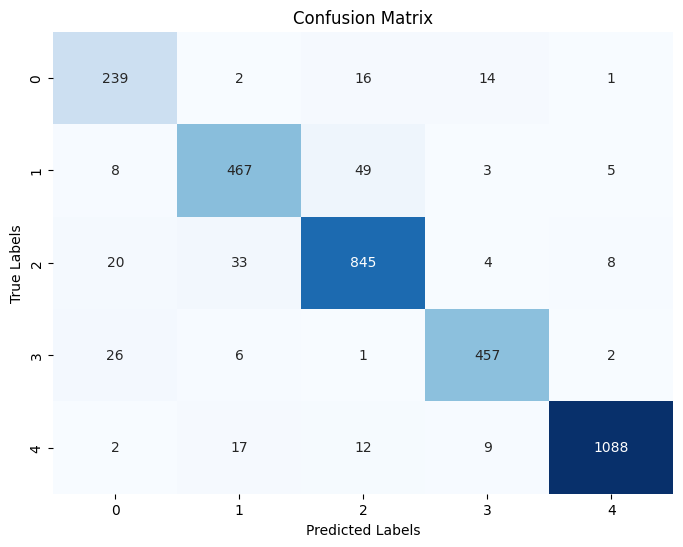

In [ ]:
from sklearn.metrics import confusion_matrix

# Tính confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# In ra confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

import matplotlib.pyplot as plt
import seaborn as sns

# Tạo biểu đồ heatmap từ confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
new_text = """

Josh Brolin is known as a doting father and movie star of epic proportions, but above all, the man is a gifted wordsmith.

Brolin – who plays Gurney Halleck in the Denis Villeneuve “Dune” movies – took a more creative approach to promoting the franchise’s second installment “Dune: Part Two” this week, by writing a unique summary of the film on social media that reads less like formulaic promotional prose and more like a Hollywood-themed riddle.

“DUNE 2 release is less than TWO WEEKS!!! Robot Lady and Wonka fall in love. Then Elvis tries to f— it all up while his bad dad floats in a pool of pond scum,” Brolin wrote on his Instagram page Tuesday. “The WWE dude from Gardians (sic) gets super pissed while Midsomer (sic) hottie puts the eyes on Wonka Obi Wan just after his Mom gets caught taking LSD in a sandy bathroom. Chigurh still doesnt like the guy from The Goonies.”

Confused? Let’s take a moment to decode which of Brolin’s “Dune: Part Two” co-stars he mentions and what on earth – or Arrakis – he’s talking about in this caption.

To start, we’re going to presume “Robot lady” is referring to Zendaya, based on this futuristic ensemble she wore to the London premiere of “Dune: Part Two” last week. And “Wonka” is obviously Timothée Chalamet, who starred as the famed chocolatier in the 2023 film and leads “Dune: Part Two” as Paul Atreides. (Both “Dune” and “Wonka” are distributed by Warner Bros. Pictures, which like CNN is owned by Warner Bros. Discovery.)

“Elvis,” of course, is Austin Butler – who still can’t seem to shake that accent after starring in 2022’s Baz Luhrmann biopic on the King of Rock ‘n’ Roll – and Brolin’s mention of “bad dad” is likely a reference to Stellan Skarsgård’s evil “Dune” character Baron Vladimir Harkonnen (who really does float in a pool of scum).

That “WWE dude” from the “Guardians of the Galaxy” franchise is Dave Bautista – who plays Glossu Rabban in the “Dune” universe – and the “hottie” is Florence Pugh, who starred in the horror film “Midsommar.”

With us so far? Great, moving on. Rebecca Ferguson is the “Mom” that Brolin mentions in reference to a certain psychedelic, which in the “Dune” universe is actually a fictional drug called Melange.
To finish, Javier Bardem played a the villainous Anton Chigurh in “No Country for Old Men” (and won an Oscar for it), and Brolin himself is the “guy from The Goonies.” Both actors, of course, figure in the second “Dune” installment, hitting theaters next week.

After the cryptic references in his post, Brolin then focused on the magic of the movies to bring things home. “I mean who doesn’t want to see all that on IMAX,” he continued to write, going on to urge his followers to “commune again and experience that amazing feeling of when the lights go down… and DUNE 2 consumes you.”

Christopher Walken, Léa Seydoux and Charlotte Rampling round out the all-star cast of “Dune: Part 2,” which is the sequel to 2021’s “Dune” and focuses on the rise of Chalamet’s heroic Paul Atreides.

The movie franchise is based on the classic 1965 “Dune” sci-fi novel by the late Frank Herbert.

“Dune: Part Two” will premiere in theaters on March 1.
”"""

In [ ]:
# Dự đoán trên dữ liệu mới
new_sequence = tokenizer.texts_to_sequences([new_text])
new_padded_sequence = pad_sequences(new_sequence, maxlen=max_length, padding='post')
predicted_label = model.predict(new_padded_sequence)

1/1 [==============================] - 0s 40ms/step


In [ ]:
predicted_label

array([[0.00445504, 0.7330125 , 0.25596777, 0.00089964, 0.00566501]],
      dtype=float32)

In [ ]:
import numpy as np
predicted_label_index = np.argmax(predicted_label)
print("Predicted label:", predicted_label_index)

Predicted label: 1


 labels = ['business', 'entertainment', 'health', 'politics', 'sport']

In [ ]:
model.save('/content/drive/MyDrive/LSTM.h5')

In [ ]:
from keras.layers import Conv1D, GlobalMaxPooling1D

# Tạo mô hình Sequential
Seq_model_cnn = Sequential()

# Thêm lớp Embedding
Seq_model_cnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))

# Thêm lớp Convolutional
Seq_model_cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# Thêm lớp Pooling
Seq_model_cnn.add(GlobalMaxPooling1D())

# Thêm lớp Dense
Seq_model_cnn.add(Dense(64, activation='relu'))

# Thêm lớp Dropout
Seq_model_cnn.add(Dropout(0.5))

# Lớp đầu ra với hàm activation softmax cho phân loại
Seq_model_cnn.add(Dense(5, activation='softmax'))

# Compile mô hình
Seq_model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history1 = Seq_model_cnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test) , callbacks=[early_stopping])

Epoch 1/50
417/417 [==============================] - 62s 140ms/step - loss: 0.6467 - accuracy: 0.7585 - val_loss: 0.1802 - val_accuracy: 0.9355
Epoch 2/50
417/417 [==============================] - 43s 103ms/step - loss: 0.1260 - accuracy: 0.9625 - val_loss: 0.1169 - val_accuracy: 0.9577
Epoch 3/50
417/417 [==============================] - 36s 86ms/step - loss: 0.0327 - accuracy: 0.9921 - val_loss: 0.1143 - val_accuracy: 0.9646
Epoch 4/50
417/417 [==============================] - 27s 64ms/step - loss: 0.0118 - accuracy: 0.9980 - val_loss: 0.1087 - val_accuracy: 0.9667
Epoch 5/50
417/417 [==============================] - 24s 59ms/step - loss: 0.0067 - accuracy: 0.9989 - val_loss: 0.1246 - val_accuracy: 0.9652
Epoch 6/50
417/417 [==============================] - 22s 52ms/step - loss: 0.0041 - accuracy: 0.9995 - val_loss: 0.1333 - val_accuracy: 0.9658
Epoch 7/50
417/417 [==============================] - 21s 51ms/step - loss: 0.0045 - accuracy: 0.9988 - val_loss: 0.1478 - val_accurac

In [ ]:
test_loss, test_accuracy = Seq_model_cnn.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

105/105 [==============================] - 1s 6ms/step - loss: 0.1087 - accuracy: 0.9667
Test Loss: 0.10871247947216034
Test Accuracy: 0.9667066335678101


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred = Seq_model_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# In classification report
print(classification_report(y_test, y_pred_classes))

105/105 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       272
           1       0.96      0.96      0.96       532
           2       0.96      0.97      0.96       910
           3       0.95      0.97      0.96       492
           4       0.99      0.98      0.99      1128

    accuracy                           0.97      3334
   macro avg       0.96      0.96      0.96      3334
weighted avg       0.97      0.97      0.97      3334



Confusion Matrix:
[[ 246    5   10   10    1]
 [   3  510   13    3    3]
 [   6    9  880    9    6]
 [   3    2    5  479    3]
 [   2    8    7    3 1108]]


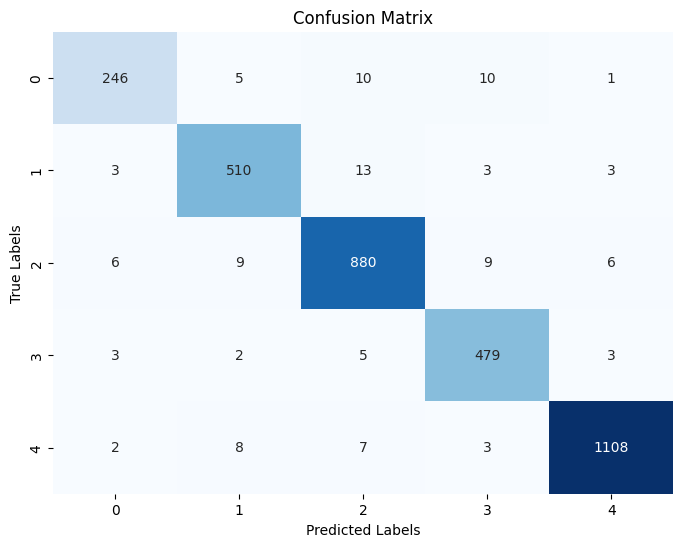

In [ ]:
from sklearn.metrics import confusion_matrix

# Tính confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# In ra confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

import matplotlib.pyplot as plt
import seaborn as sns

# Tạo biểu đồ heatmap từ confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
Seq_model_cnn.save('/content/drive/MyDrive/Seq_model_cnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predictions_cnn = Seq_model_cnn.predict(new_padded_sequence)

1/1 [==============================] - 0s 159ms/step


In [ ]:
predictions_cnn

array([[3.9799776e-08, 9.9999940e-01, 5.9635454e-07, 1.1231965e-10,
        5.6607735e-10]], dtype=float32)

In [ ]:
import numpy as np
predicted_label_cnn = np.argmax(predictions_cnn)
print("Predicted label:", predicted_label_cnn)

Predicted label: 1


In [ ]:
import tensorflow as tf
print("GPU Available: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available:  True


## ***Testing***

In [ ]:
new_text = """

Josh Brolin is known as a doting father and movie star of epic proportions, but above all, the man is a gifted wordsmith.

Brolin – who plays Gurney Halleck in the Denis Villeneuve “Dune” movies – took a more creative approach to promoting the franchise’s second installment “Dune: Part Two” this week, by writing a unique summary of the film on social media that reads less like formulaic promotional prose and more like a Hollywood-themed riddle.

“DUNE 2 release is less than TWO WEEKS!!! Robot Lady and Wonka fall in love. Then Elvis tries to f— it all up while his bad dad floats in a pool of pond scum,” Brolin wrote on his Instagram page Tuesday. “The WWE dude from Gardians (sic) gets super pissed while Midsomer (sic) hottie puts the eyes on Wonka Obi Wan just after his Mom gets caught taking LSD in a sandy bathroom. Chigurh still doesnt like the guy from The Goonies.”

Confused? Let’s take a moment to decode which of Brolin’s “Dune: Part Two” co-stars he mentions and what on earth – or Arrakis – he’s talking about in this caption.

To start, we’re going to presume “Robot lady” is referring to Zendaya, based on this futuristic ensemble she wore to the London premiere of “Dune: Part Two” last week. And “Wonka” is obviously Timothée Chalamet, who starred as the famed chocolatier in the 2023 film and leads “Dune: Part Two” as Paul Atreides. (Both “Dune” and “Wonka” are distributed by Warner Bros. Pictures, which like CNN is owned by Warner Bros. Discovery.)

“Elvis,” of course, is Austin Butler – who still can’t seem to shake that accent after starring in 2022’s Baz Luhrmann biopic on the King of Rock ‘n’ Roll – and Brolin’s mention of “bad dad” is likely a reference to Stellan Skarsgård’s evil “Dune” character Baron Vladimir Harkonnen (who really does float in a pool of scum).

That “WWE dude” from the “Guardians of the Galaxy” franchise is Dave Bautista – who plays Glossu Rabban in the “Dune” universe – and the “hottie” is Florence Pugh, who starred in the horror film “Midsommar.”

With us so far? Great, moving on. Rebecca Ferguson is the “Mom” that Brolin mentions in reference to a certain psychedelic, which in the “Dune” universe is actually a fictional drug called Melange.
To finish, Javier Bardem played a the villainous Anton Chigurh in “No Country for Old Men” (and won an Oscar for it), and Brolin himself is the “guy from The Goonies.” Both actors, of course, figure in the second “Dune” installment, hitting theaters next week.

After the cryptic references in his post, Brolin then focused on the magic of the movies to bring things home. “I mean who doesn’t want to see all that on IMAX,” he continued to write, going on to urge his followers to “commune again and experience that amazing feeling of when the lights go down… and DUNE 2 consumes you.”

Christopher Walken, Léa Seydoux and Charlotte Rampling round out the all-star cast of “Dune: Part 2,” which is the sequel to 2021’s “Dune” and focuses on the rise of Chalamet’s heroic Paul Atreides.

The movie franchise is based on the classic 1965 “Dune” sci-fi novel by the late Frank Herbert.

“Dune: Part Two” will premiere in theaters on March 1.
”"""

In [ ]:
# Dự đoán trên dữ liệu mới
new_sequence = tokenizer.texts_to_sequences([new_text])
new_padded_sequence = pad_sequences(new_sequence, maxlen=max_length, padding='post')
predicted_label = model.predict(new_padded_sequence)

1/1 [==============================] - 0s 40ms/step


In [ ]:
predicted_label

array([[0.00445504, 0.7330125 , 0.25596777, 0.00089964, 0.00566501]],
      dtype=float32)

In [ ]:
import numpy as np
predicted_label_index = np.argmax(predicted_label)
print("Predicted label:", predicted_label_index)

Predicted label: 1


 labels = ['business', 'entertainment', 'health', 'politics', 'sport']

# ***Combat With Imbalance Dataset 👊***

## Craw More Data for Minority Class 🦐

In [ ]:
import requests
from bs4 import BeautifulSoup
from xml.etree import ElementTree as ET
import csv

In [ ]:
# Define the CSV file path
csv_file = '/content/Get_Data.csv'

# List of sitemap URLs
sitemap_urls = [
    'https://edition.cnn.com/sport/article/sitemap-2023-2.html',
    'https://us.cnn.com/politics/article/sitemap-2023-1.html',
]

In [ ]:
# Open the CSV file in write mode and specify the header
with open(csv_file, 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # Write the header row
    writer.writerow(['Author', 'Date Published', 'Category', 'URL', 'Headline', 'Description', 'Keywords', 'Article text'])

    # Iterate over each sitemap URL
    for sitemap_url in sitemap_urls:
        logging.info(f"Fetching sitemap: {sitemap_url}")
        # Fetch the sitemap
        response = requests.get(sitemap_url)

        # Parse the sitemap HTML
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find all anchor tags that are children of span tags with class 'sitemap-link'
        urls = [span.a['href'] for span in soup.find_all('span', class_='sitemap-link') if span.a]

        # Crawl pages and extract data
        for url in urls:
            try:
                print(f"Crawling page: {url}")
                # Fetch page content
                page_response = requests.get(url)
                page_content = page_response.content

                # Parse page content with BeautifulSoup
                soup = BeautifulSoup(page_content, 'html.parser')

                # Extract data you need from the page
                author = soup.find("meta", {"name": "author"}).attrs['content'].strip()
                date_published = soup.find("meta", {"property": "article:published_time"}).attrs['content'].strip()
                article_section = soup.find("meta", {"name": "meta-section"}).attrs['content']
                url = soup.find("meta", {"property": "og:url"}).attrs['content']
                headline = soup.find("h1", {"data-editable": "headlineText"}).text.strip()
                description = soup.find("meta", {"name": "description"}).attrs['content'].strip()
                keywords = soup.find("meta", {"name": "keywords"}).attrs['content'].strip()
                text = soup.find(itemprop="articleBody")
                # Find all <p> tags with class "paragraph inline-placeholder"
                paragraphs = text.find_all('p', class_="paragraph inline-placeholder")

                # Initialize an empty list to store the text content of each paragraph
                paragraph_texts = []

                # Iterate over each <p> tag and extract its text content
                for paragraph in paragraphs:
                    paragraph_texts.append(paragraph.text.strip())

                # Join the text content of all paragraphs into a single string
                full_text = ''.join(paragraph_texts)
                # Write the extracted data to the CSV file
                writer.writerow([author, date_published, article_section, url, headline, description, keywords, full_text])

            except Exception as e:
                print(f"Failed to crawl page: {url}, Error: {str(e)}")

print("Data extraction and writing to CSV completed successfully.")

In [ ]:
# Read file A and file B into Pandas DataFrames
file_a = pd.read_csv('/content/drive/MyDrive/ClassificationProject/Normalize_Dataset.csv', lineterminator='\n')
file_b = pd.read_csv('/content/Entertainment.csv')

# Merge file B into file A using DataFrame.append()
# Merge files B, C, and D into file A using DataFrame.append()
merged_df = pd.concat([file_a, file_b], ignore_index=False)
merged_df = merged_df.drop(columns=['Index'])
# Save the merged DataFrame back to a CSV file
merged_df.to_csv('merged_file.csv', index=True)  # Set index=True to include the index in the CSV file


In [ ]:
df = pd.read_csv('/content/Get_Data.csv', lineterminator='\n')

In [ ]:
# Get the number of rows in the DataFrame
num_rows = len(df)

print("Number of rows in the DataFrame:", num_rows)
print(df['Category'].value_counts())

Number of rows in the DataFrame: 460
entertainment    245
health           119
business          96
Name: Category, dtype: int64


# ***Model Persistence 🗄️***

In [ ]:
import joblib

In [ ]:
# joblib.dump(logistic_model, "Logistic_Model.joblib")
joblib.dump(svm_classifier, "SVM_Linear_Kernel.joblib")
# joblib.dump(rbf_model, "SVM_RBF_Model.joblib")
# joblib.dump(poly_model, "SVM_POLY_Model.joblib")

# Save the model using the save() method provided by the Keras API.
# Seq_model.save('Sequentail_model.h5')

# save the vetorized (vocabulary for model)
# joblib.dump(vectorizer, 'vectorizer.joblib')

['vectorizer.joblib']

In [ ]:
print(vectorizer)

# ***Exploratory Data Analysis*** 📈

In [ ]:
import pandas as pd

## Read dataset



In [ ]:
data = pd.read_csv("/content/drive/MyDrive/ClassificationProject/New_Crawler/New_Crawler_Complete_Processed_Dataset.csv", lineterminator='\n').convert_dtypes()

## Creating Meaningful Column Names

In [ ]:
# Rename some columns in dataset
new_column_names = {
    "Unnamed: 0": "Index",
    "Date published": "Date_Published",
    "Article text": "Article_Text",
}
data = data.rename(columns=new_column_names)

In [ ]:
data.columns

## Dealing With Missing Data

In [ ]:
# Result will display some columns that contain null value
# But in reality, the key columns is Article_Text and Category and
# these two columns did not contain any null value
# So we do not need to drop any row since that will not affect our objective
data.info()

In [ ]:
# Display row containing null value
data.loc[data.isna().any(axis="columns")]

## Correcting Invalid Data Types

In [ ]:
# Result: All the columns have their own correct data type
# Except the date column which it should be date type not string type
data.info()

In [ ]:
# Convert Date Column to Date Type
data = data.assign(
    Date_Published = lambda data:pd.to_datetime(
        data["Date_Published"]
    ),
)

In [ ]:
data.info() # testing after processing

## Correcting Spelling Errors

In [ ]:
data["Category"].value_counts()

## Removing Duplicate Data

In [ ]:
# Result: there is no duplicate in our dataset
# Solution to remove duplicate observation in Pandas
# .drop_duplicates(ignore_index=True)
data.loc[data.duplicated(keep=False)]

## Storing Cleansed Data

In [ ]:
data.to_csv("New_Crawler_After_EDA_And_Complete_Processing.csv", index=False)

# **Performing Data Analysis Using Python 📍**

## Import Dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/ClassificationProject/New_Crawler/New_Crawler_After_EDA_And_Complete_Processed.csv", lineterminator='\n').convert_dtypes()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ClassificationProject/New_Crawler/New_Crawler_After_EDA_And_Complete_Processed.csv'

In [ ]:
data.columns

## Category Distribution

In [ ]:
# Get the category counts
category_counts = data["Category"].value_counts()

# Sort the counts in descending order
sorted_counts = category_counts.sort_values(ascending=False)

# Define colors for each category
colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow']

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize to make the graph wider

# Plot the bar chart with specified colors
bars = sorted_counts.plot.bar(
    ax=ax,
    title="Category Distribution",
    xlabel="Category",
    ylabel="Count",
    color=colors,  # Use the predefined colors
)

# Annotate each bar with its count
for bar in bars.patches:
    # Get the count for the current bar
    count = bar.get_height()
    # Annotate the bar with its count
    ax.annotate(f'{count}',
                (bar.get_x() + bar.get_width() / 2, count),
                ha='center', va='bottom')

# Rotate the x-axis labels vertically
plt.xticks(rotation=90)

# Show the plot
plt.show()


## Years **Distribution**

In [ ]:
date_distribution = data['Date published'].value_counts()

# Extract the year from the 'Date_Published' column
data['Year published'] = pd.to_datetime(data['Date published']).dt.year

# Calculate the distribution of years
year_distribution = data['Year published'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))  # Set the figure size
plt.pie(year_distribution, labels=year_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Year Published')  # Add a title
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

## Number of Authors

In [ ]:
# Calculate the total number of unique authors
total_authors = data['Author'].nunique()

# Create a bar chart
plt.bar('Total Unique Authors', total_authors, color='skyblue')

# Add labels and title
plt.title('Total Unique Authors')


# Add text annotations on top of each bar
for i, count in enumerate([total_authors]):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Show the plot
plt.show()

# ***Backend Server - Flask 🔑***

In [ ]:
import joblib # Load Joblib file
import json # Load JSON file
from sklearn.feature_extraction.text import CountVectorizer # Convert text to BOW format
from flask import Flask, request, jsonify # Flask Server
from tensorflow.keras.preprocessing.text import Tokenizer # tokenizing text documents into sequences of tokens (Seq Model)
from tensorflow.keras.preprocessing.sequence import pad_sequences # ensure that all sequences in a dataset have the same length (Seq Model)
from tensorflow.keras.models import load_model # load a pre-trained Keras model saved in the Hierarchical Data Format (HDF5) file format
import numpy as np # scientific computing in Python

In [ ]:
# load all the models and vectorizer (global vocabulary)
Seq_model = load_model('Sequentail_model.h5') # Sequential
SVM_Linear_model = joblib.load("/content/SVM_Linear_Model.joblib") # SVM
logistic_model = joblib.load("/content/Logistic_Model.joblib") # Logistic
vectorizer = joblib.load('vectorizer.joblib') # global vocabulary

In [ ]:
def process_api(text):
    # Vectorize the text data
    processed_text = vectorizer.transform([text])

    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=500, padding='post')

    # Get the predicted result from models
    Seq_Predicted = Seq_model.predict(padded_sequence)
    SVM_Linear_Predicted = SVM_Linear_model.predict(processed_text).tolist()
    Logistic_Predicted = logistic_model.predict(processed_text).tolist()

    predicted_probabilities = Seq_Predicted.tolist(),
    index_of_max_probability = np.argmax(predicted_probabilities).tolist()
    return {
        'Seq_Predicted':index_of_max_probability,
        'SVM_Linear_Predicted': SVM_Linear_Predicted[0],
        'Logistic_Predicted': Logistic_Predicted[0]
    }

In [ ]:
# Using Model to handle and return Category Route
@app.route('/api/categorize', methods=['POST'])
def categorize():
    try:
        data = request.get_json()  # Get JSON data from the request body
        text = data['text']  # Get the value of the 'text' key
        result = process_api(text)
        return jsonify(result), 200
    except:
        return jsonify("No text found in the response body"), 400

In [ ]:
# Return blogs_from_CNN list
@app.route('/api/blogs', methods=['GET'])
def blog_list():
    # Specify the path to the uploaded JSON file: [GET] API Blogs
    json_file_path = '/content/Get_Data_Minimize.json'
    # Read and parse the JSON data directly
    with open(json_file_path, 'r') as f:
        blogs_from_cnn = json.load(f)

    # Python's default behavior is to represent strings with single quotes when printed
    # When you print the loaded JSON data in Python,
    # you might see the representation with single quotes,
    # but it doesn't mean the strings have been converted or altered.
    print(blogs_from_cnn)

    for blog in blogs_from_cnn:
        result = process_api(blog['Article text'])
        blog.update(result)
        print(blog)
    return jsonify(blog), 200